<a href="https://colab.research.google.com/github/anubhavgupta1/Udacity/blob/main/Frameworks/Pytorch/CNNs/Deep%20Architectures/CUDA/Model%20Zoo/VGG/%20VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [2]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

Tesla T4
1


In [3]:
gpu = torch.device('cuda:0')
gpu

device(type='cuda', index=0)

## Dataset, transforms, and visualisation

In [4]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
num_classes = 10

In [7]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

#VGG Model

In [8]:
from torchvision import models

In [9]:
vgg = models.vgg16_bn()

In [10]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [11]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [12]:
print(vgg.classifier[6])
print(vgg.classifier[6].in_features)
print(vgg.classifier.children())

Linear(in_features=4096, out_features=1000, bias=True)
4096
<generator object Module.children at 0x7faf31ca1048>


In [13]:
for feature in list(vgg.classifier.children())[:-1]:
  print(feature)

Linear(in_features=25088, out_features=4096, bias=True)
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=4096, out_features=4096, bias=True)
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)


In [14]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
for feature in mod_classifier:
  print(feature)

Linear(in_features=25088, out_features=4096, bias=True)
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=4096, out_features=4096, bias=True)
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=4096, out_features=10, bias=True)


In [15]:
vgg.classifier = nn.Sequential(*mod_classifier)

In [16]:
print(vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


## VGG Model Class

In [17]:
class vgg_network():

    def forward(self, model,X):
        return model(X)
    
    def evaluation(self,model, dataloader):
        total, correct = 0, 0
        for data in dataloader:
          inputs, labels = data
          inputs, labels = inputs.to(gpu), labels.to(gpu)
          outputs = self.forward(model, inputs)
          _, pred = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (pred == labels).sum().item()
        return 100 * correct / total
    
    def fit(self, model, epochs,trainloader,testloader,loss_fn,opt,batch_size):
          max_epochs =  epochs
          loss_arr = []
          loss_epoch_arr = []
          n_iters = np.ceil(50000/batch_size)
          for epoch in range(epochs):
              for i, data in enumerate(trainloader, 0):
                  
                  inputs, labels = data
                  inputs, labels = inputs.to(gpu), labels.to(gpu)
                  
                  opt.zero_grad()
                  
                  outputs = self.forward(model,inputs)
                  loss = loss_fn(outputs, labels)
                  loss.backward()
                  opt.step()

                  del inputs, labels, outputs
                  torch.cuda.empty_cache()
                  
                  print('Iteration: %d/%d, Loss: %0.2f' % (i+1, n_iters, loss.item()))

                  loss_arr.append(loss.item())
              
              loss_epoch_arr.append(loss.item())
              train_acc = self.evaluation(model,trainloader)
              test_acc = self.evaluation(model,testloader)
              print('Epoch: %d/%d, Train acc: %0.2f, Test acc: %0.2f' % (epoch+1, max_epochs, train_acc,test_acc ) )
          plt.plot(loss_arr)
          plt.show()

Iteration: 1/3125, Loss: 2.42
Iteration: 2/3125, Loss: 13.47
Iteration: 3/3125, Loss: 101.50
Iteration: 4/3125, Loss: 4.04
Iteration: 5/3125, Loss: 13.94
Iteration: 6/3125, Loss: 4.93
Iteration: 7/3125, Loss: 6.53
Iteration: 8/3125, Loss: 2.98
Iteration: 9/3125, Loss: 14.25
Iteration: 10/3125, Loss: 7.68
Iteration: 11/3125, Loss: 47.46
Iteration: 12/3125, Loss: 4.01
Iteration: 13/3125, Loss: 189.51
Iteration: 14/3125, Loss: 50.95
Iteration: 15/3125, Loss: 18.04
Iteration: 16/3125, Loss: 22.61
Iteration: 17/3125, Loss: 9.25
Iteration: 18/3125, Loss: 2.02
Iteration: 19/3125, Loss: 9.73
Iteration: 20/3125, Loss: 9.71
Iteration: 21/3125, Loss: 2.18
Iteration: 22/3125, Loss: 28.71
Iteration: 23/3125, Loss: 44.86
Iteration: 24/3125, Loss: 298.86
Iteration: 25/3125, Loss: 791.96
Iteration: 26/3125, Loss: 50.94
Iteration: 27/3125, Loss: 296.15
Iteration: 28/3125, Loss: 31.26
Iteration: 29/3125, Loss: 25.37
Iteration: 30/3125, Loss: 1108.31
Iteration: 31/3125, Loss: 4102.49
Iteration: 32/3125, 

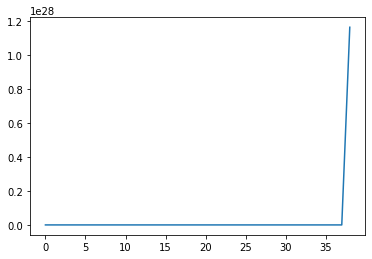

CPU times: user 13min 31s, sys: 8min 10s, total: 21min 41s
Wall time: 21min 49s


In [18]:
%%time
vgg = vgg.to(gpu)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)
model = vgg_network()
model.fit(vgg,1,trainloader,testloader,loss_fn,opt,batch_size)